In [3]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 13.9 MB/s eta 0:00:00


In [4]:
import pandas as pd
import re
import string

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [5]:
# Stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Stopword
stop_factory = StopWordRemoverFactory()
stopwords = set(stop_factory.get_stop_words())


In [6]:
kamus_normalisasi = {
    "gk": "tidak",
    "ga": "tidak",
    "nggak": "tidak",
    "tdk": "tidak",
    "yg": "yang",
    "aja": "saja",
    "bgt": "banget",
    "bangett": "banget",
    "kalo": "kalau",
    "dgn": "dengan",
    "pdhl": "padahal",
    "sm": "sama",
    "trs": "terus",
    "krn": "karena",
    "dlm": "dalam"
}


In [7]:
def preprocessing_text(text):
    if pd.isnull(text):
        return ""

    # Case folding
    text = text.lower()

    # Hapus non ASCII
    text = text.encode('ascii', 'ignore').decode()

    # Hapus URL
    text = re.sub(r"http\S+|www\S+", "", text)

    # Hapus angka
    text = re.sub(r"\d+", "", text)

    # Hapus tanda baca / punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Hapus whitespace berlebih
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenisasi
    tokens = text.split()

    hasil = []
    for token in tokens:
        # Normalisasi huruf ganda (asikkk → asik)
        token = re.sub(r'(.)\1+', r'\1', token)

        # Normalisasi typo & kata gaul
        if token in kamus_normalisasi:
            token = kamus_normalisasi[token]

        # Hapus kata ≤ 3 huruf
        if len(token) <= 3:
            continue

        # Stopword removal
        if token in stopwords:
            continue

        # Stemming
        token = stemmer.stem(token)

        hasil.append(token)

    return " ".join(hasil)


In [8]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UlasanGRAB_CaseFold (1).csv")

df['content_clean'] = df['content'].apply(preprocessing_text)


In [9]:
print(df[['content', 'content_clean']].head())

                                             content  \
0  pengalaman terburuk saya semalam dokumen saya ...   
1  Masih Banyak Driver yang meminta uang lebih da...   
2                              recomen,bnyk membantu   
3                  fdk bisa atur ulang aplikasi greb   
4                                              bagus   

                                       content_clean  
0  alam buruk malam dokumen driver driver suruh a...  
1  banyak driver minta uang lebih aplikasi transa...  
2                                  recomenbnyk bantu  
3                           atur ulang aplikasi greb  
4                                              bagus  


In [10]:
output_path = "/content/drive/MyDrive/Colab Notebooks/UlasanGRAB_Lengkap_Bersih.csv"

df.to_csv(output_path, index=False)

print("Berhasil disimpan!")
print("Jumlah kolom:", df.shape[1])
print("Nama kolom:", df.columns.tolist())


Berhasil disimpan!
Jumlah kolom: 15
Nama kolom: ['reviewId', 'userName', 'userImage', 'content', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent', 'repliedAt', 'appVersion', 'content_casefold', 'replyContent_casefold', 'score_casefold', 'content_clean']


# CLUSTERING K-MEANS

In [11]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [12]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UlasanGRAB_Lengkap_Bersih.csv")
df = df[df['content_clean'].notna()]
df = df[df['content_clean'] != ""]

In [13]:
tfidf = TfidfVectorizer(
    max_features=2000,
    min_df=5,
    max_df=0.8
)

X_tfidf = tfidf.fit_transform(df['content_clean'])

In [14]:
range_k = range(2, 7)
scores = []

for k in range_k:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_tfidf)
    score = silhouette_score(X_tfidf, labels)
    scores.append(score)
    print(f"Jumlah cluster {k} → Silhouette Score: {score:.4f}")

Jumlah cluster 2 → Silhouette Score: 0.0477
Jumlah cluster 3 → Silhouette Score: 0.0994
Jumlah cluster 4 → Silhouette Score: 0.1168
Jumlah cluster 5 → Silhouette Score: 0.1677
Jumlah cluster 6 → Silhouette Score: 0.1587


In [15]:
kmeans = KMeans(
    n_clusters=5,
    random_state=42
)

df['cluster'] = kmeans.fit_predict(X_tfidf)

In [16]:
print(df['cluster'].value_counts())

cluster
1    627
3     99
4     91
2     60
0     15
Name: count, dtype: int64


In [17]:
terms = tfidf.get_feature_names_out()

for i in range(3):
    print(f"\nCluster {i}")
    centroid = kmeans.cluster_centers_[i]
    top_terms = centroid.argsort()[-10:][::-1]
    print(", ".join([terms[j] for j in top_terms]))


Cluster 0
aman, nyaman, cepat, antar, terima, alhamdulilah, kasih, drivernya, buat, kemudi

Cluster 1
baik, ramah, driver, grab, banget, nyaman, aplikasi, cepat, layan, pesan

Cluster 2
mantap, layan, grab, sangat, ribet, driver, bagus, jalan, nyaman, verifikasi


In [18]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

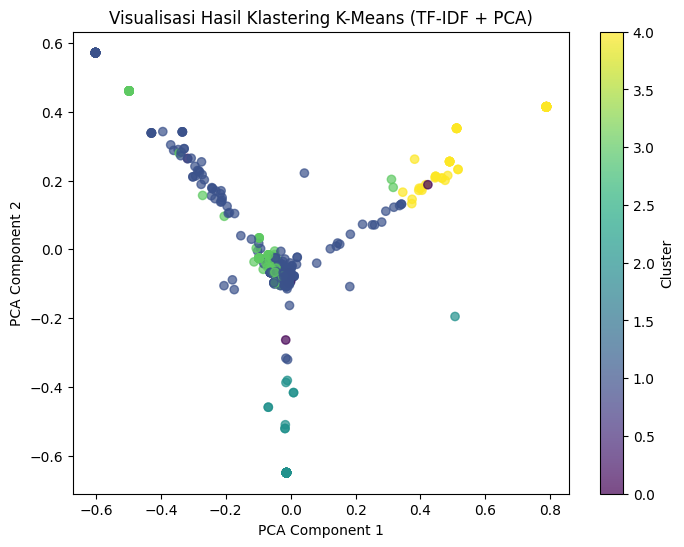

In [19]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=df['cluster'],
    alpha=0.7
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Visualisasi Hasil Klastering K-Means (TF-IDF + PCA)")
plt.colorbar(scatter, label="Cluster")

plt.show()

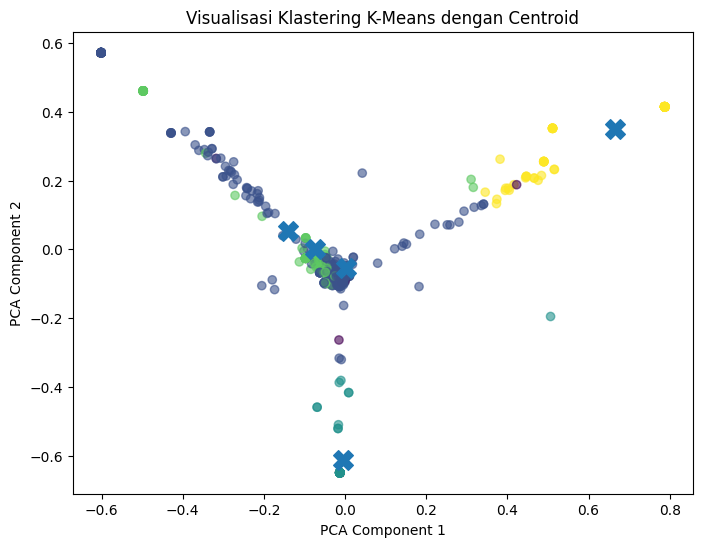

In [20]:
centroids_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], alpha=0.6)
plt.scatter(
    centroids_pca[:, 0],
    centroids_pca[:, 1],
    marker='X',
    s=200
)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Visualisasi Klastering K-Means dengan Centroid")
plt.show()

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [22]:
count_vectorizer = CountVectorizer(
    max_features=2000,
    min_df=5,
    max_df=0.8
)

X_count = count_vectorizer.fit_transform(df['content_clean'])

In [23]:
lda = LatentDirichletAllocation(
    n_components=5,
    random_state=42,
    learning_method='batch'
)

lda.fit(X_count)

LatentDirichletAllocation(n_components=5, random_state=42)

In [24]:
feature_names = count_vectorizer.get_feature_names_out()

for idx, topic in enumerate(lda.components_):
    print(f"\nTopik {idx}")
    top_words = topic.argsort()[-10:][::-1]
    print(", ".join([feature_names[i] for i in top_words]))


Topik 0
baik, ramah, layan, waktu, tepat, aman, nyaman, selalu, kemudi, mobil

Topik 1
mantap, grab, bayar, udah, kasih, terima, makin, masuk, susah, tunai

Topik 2
bagus, banget, grab, sekali, aplikasi, murah, padahal, diskon, lama, banyak

Topik 3
driver, aplikasi, grab, pesan, buat, kalau, lebih, lama, banyak, jadi

Topik 4
sangat, bantu, cepat, mudah, nyaman, jalan, puas, sopan, keren, grab


In [25]:
topic_distribution = lda.transform(X_count)
df['topic'] = topic_distribution.argmax(axis=1)

In [26]:
print(df['topic'].value_counts())

topic
0    270
2    196
4    165
3    133
1    128
Name: count, dtype: int64


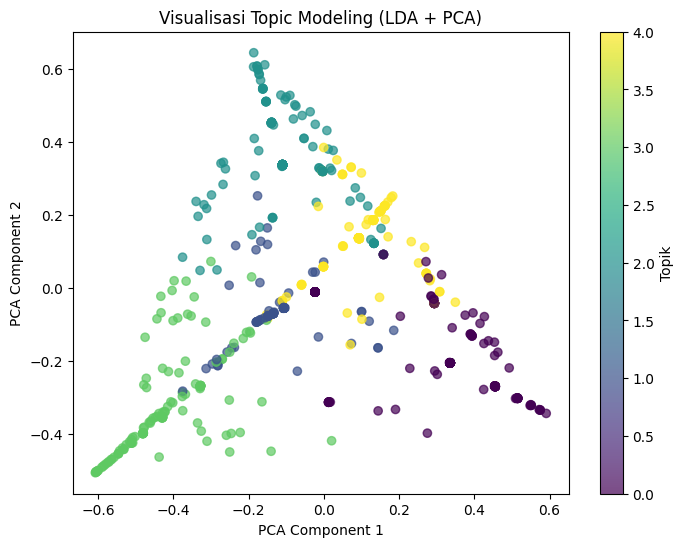

In [27]:
pca_topic = PCA(n_components=2, random_state=42)
X_topic_pca = pca_topic.fit_transform(topic_distribution)

plt.figure(figsize=(8, 6))
plt.scatter(X_topic_pca[:, 0], X_topic_pca[:, 1], c=df['topic'], alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Visualisasi Topic Modeling (LDA + PCA)")
plt.colorbar(label="Topik")
plt.show()